### Setup

In [11]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Import

In [2]:
f = 'loan_clean.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [3]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default,default_harsh,had_delinq,had_major_derog,had_record,annual_inc_merged,dti_merged,rev_util_custom,rev_lim_custom,tot_cur_bal_filled,tot_cur_bal_med,had_collections,verification_status_merged,earliest_cr_line_td
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,24000.0,27.65,83.7,16305.854241,15008.0,15008.0,0,Verified,-9830
1077430,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1,1,0,0,0,30000.0,1.00,9.4,17946.808511,24713.0,24713.0,0,Source Verified,-4627
1077175,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,12252.0,8.72,98.5,3001.015228,15008.0,15008.0,0,Not Verified,-3682
1076863,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,1,0,0,49200.0,20.00,21.0,26657.142857,49042.0,49042.0,0,Source Verified,-5782
1075269,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,n,wedding,852xx,AZ,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,161.03,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0,0,0,0,0,36000.0,11.20,28.3,28137.809187,30048.0,30048.0,0,Source Verified,-2586


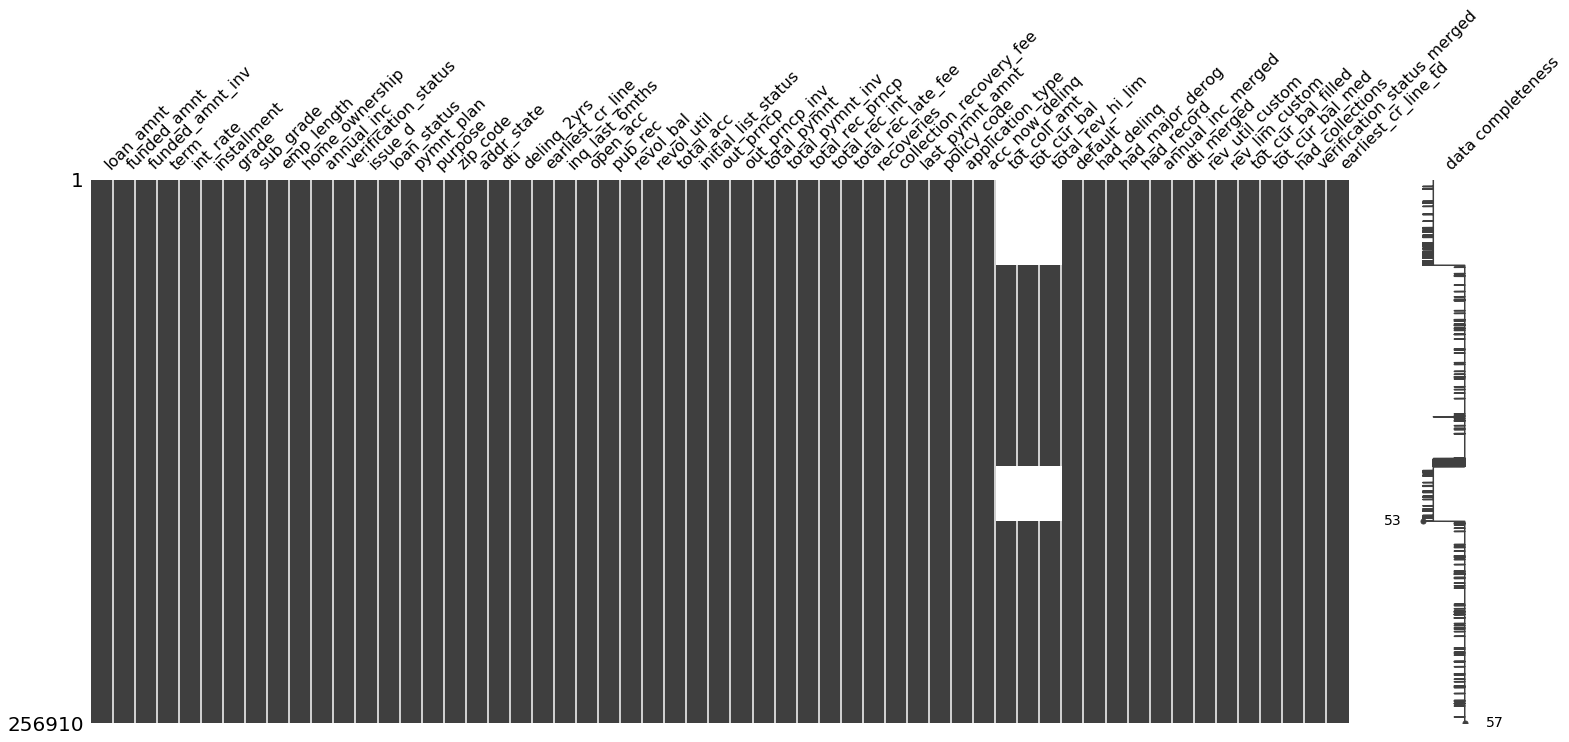

In [13]:
msno.matrix(data, labels=True)

In [14]:
data.isnull().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_length                        0
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      211
total_acc                         0
initial_list_status         

### Target Variable

For this classification problem, our goal is to identify loans that will default. The original column capturing this information is <i>loan_status</i>, however these values extend beyond simple default/paid, so this has to be simplified into a binary true/false value.

During initial data cleaning two new column were created: one identifying basic default loans (status of Default of Charged Off), and one which was more unforgiving in classifying defaults by including any late loans as well. For the purpose of this MVP analysis, we will keep things simple and focus on the basic definition of a defualt loan.

As for the other statuses, all current loans need to be removed from the dataset. Analysis can only be conducted on loans that have completed their term or been written off, since otherwise ther is no way of knowing the terminal status of paid / default. The basic current / active loans were already removed during data cleaning, but we will also need to drop the 'late' loans since we are opting to not identify these as default.

In [5]:
# Extract late loans
late_mask = data['loan_status'].str.contains('Late')
data_late = data[late_mask]

In [4]:
# Save late loan data in separate file
f = 'loan_late.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'wb') as file:
    pickle.dump(data_late, file)

In [6]:
# Remove late status entries
data = data[~late_mask].copy()

In [7]:
data['loan_status'].value_counts()

Fully Paid     209685
Charged Off     46006
Default          1219
Name: loan_status, dtype: int64

In [8]:
data['default'].value_counts()

0    209685
1     47225
Name: default, dtype: int64

In [9]:
# Drop alternative default status column used for including late status loans as default
data.drop('default_harsh', axis=1, inplace=True)

In [10]:
target = data['default']

### Feature Selection

For the purpose of this MVP analysis and setting some basic benchmarks for comparison with more in-depth models, feature selection will be limited to a few key variables, which based off the data analysis thus far (see EDA) one would anticipate to influence whether a loan defaults:

In [20]:
num_attr = ['annual_inc_merged', 'int_rate', 'dti_merged', 'rev_util_custom', 'rev_lim_custom', 'tot_cur_bal_filled', 'loan_amnt', 'installment',
            'inq_last_6mths', 'earliest_cr_line_td', 'total_acc', 'open_acc', 'delinq_2yrs', 'pub_rec', 'collection_recovery_fee',
            'acc_now_delinq', 'had_delinq', 'had_major_derog', 'had_record', 'had_collections']

cat_attr = ['grade','sub_grade', 'emp_length', 'purpose', 'home_ownership', 'verification_status_merged', 'application_type', 'term']

Note that any columns containing payment summaries have been deliberately omitted. The reasoning for this is that these values can only be known after a loan has completed its term. Consequently, these values do not reflect he loans properties at the time of issuing and/or initial investment, which is what our analysis is interested in.

Preparing the basic pipelines to set up the new dataframe:

In [21]:
# Class for selecting attributes from a dataframe, for use in pipelines

class DataFrame_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [22]:
class DataFrame_DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dummies = pd.get_dummies(X[self.attribute_names])
        return dummies.values

In [23]:
num_pipeline = Pipeline([('selector', DataFrame_Selector(num_attr)),
                         ('std_scaler', StandardScaler())])

cat_pipeline = Pipeline([('selector', DataFrame_DummyEncoder(cat_attr))])

prep_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                               ('cat_pipeline', cat_pipeline)])

In [24]:
data_prepared = prep_pipeline.fit_transform(data)

In [29]:
data_prepared.shape

(256910, 101)

### Modeling

##### Train/Test Split

In [25]:
X = data_prepared
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression


In [26]:
logreg = LogisticRegression()

In [27]:
logreg_cvs = cross_val_score(estimator=logreg, X=X_train, y=y_train, cv=10, scoring='f1', n_jobs=-1)
logreg_cvs.mean()

0.5783686745105322

In [30]:
logreg.fit(X_train, y_train);
train_predict = logreg.predict(X_train)
test_predict = logreg.predict(X_test)

In [31]:
f1_score(train_predict, y_train)

0.51486857591212243

In [32]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 100]}

logreg_gs = GridSearchCV(estimator=logreg,
                  param_grid = param_grid,
                  scoring='f1',
                  cv=3,
                  n_jobs=-1)

logreg_gs.fit(X_train, y_train);

In [33]:
logreg_gs.best_score_

0.56474083571877298

In [34]:
logreg_gs.best_params_

{'C': 100}

In [ ]:
logreg_best = logreg_gs.best_estimator_

In [ ]:
logreg_cvs = cross_val_score(estimator=logreg_best, X=X_train, y=y_train, cv=10, scoring='f1', n_jobs=-1)
logreg_cvs.mean()

### Naive Bayes Classifier

##### KNN

In [25]:
knc = KNeighborsClassifier()

In [28]:
KNeighborsClassifier?

In [27]:
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knc_pred = knc.predict(X_train)

In [ ]:
f1_score(knc_pred, y_train)

In [ ]:
knc_cvs = cross_val_score(estimator=knc, X=X_train, y=y_train, cv=3, scoring='f1', n_jobs=5)
knc_cvs.mean()

In [ ]:
1

##### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, criterion='gini', max_features=0.2, n_jobs=-1)
model.fit(data_prepared, target)
f1_score(model.predict(data_prepared), target)

In [ ]:
confusion_matrix(model.predict(data_prepared), target)